# Protect Spaces

This notebook outlines the general workflow for the data within the Protect Spaces page.

Unless otherwise noted, all polygonal calculations were done in the Mollweide Projection (ESRI:54009)

## Total Area Tags (0)

Take totals from global statistics documents (https://www.protectedplanet.net/en), sum the area of the 2023 shapes (using ESRI:54009, Global Mollweide) and Calculate the growth using the given totals and the 2023 values.

For each kind of protection (All, MPA, OECM):

`Current Area` - `2023 Area` = `Change In Area`

`Percent Change` = `Change in Area` / `2013 Area` - 1

## Protection Time Series (1)

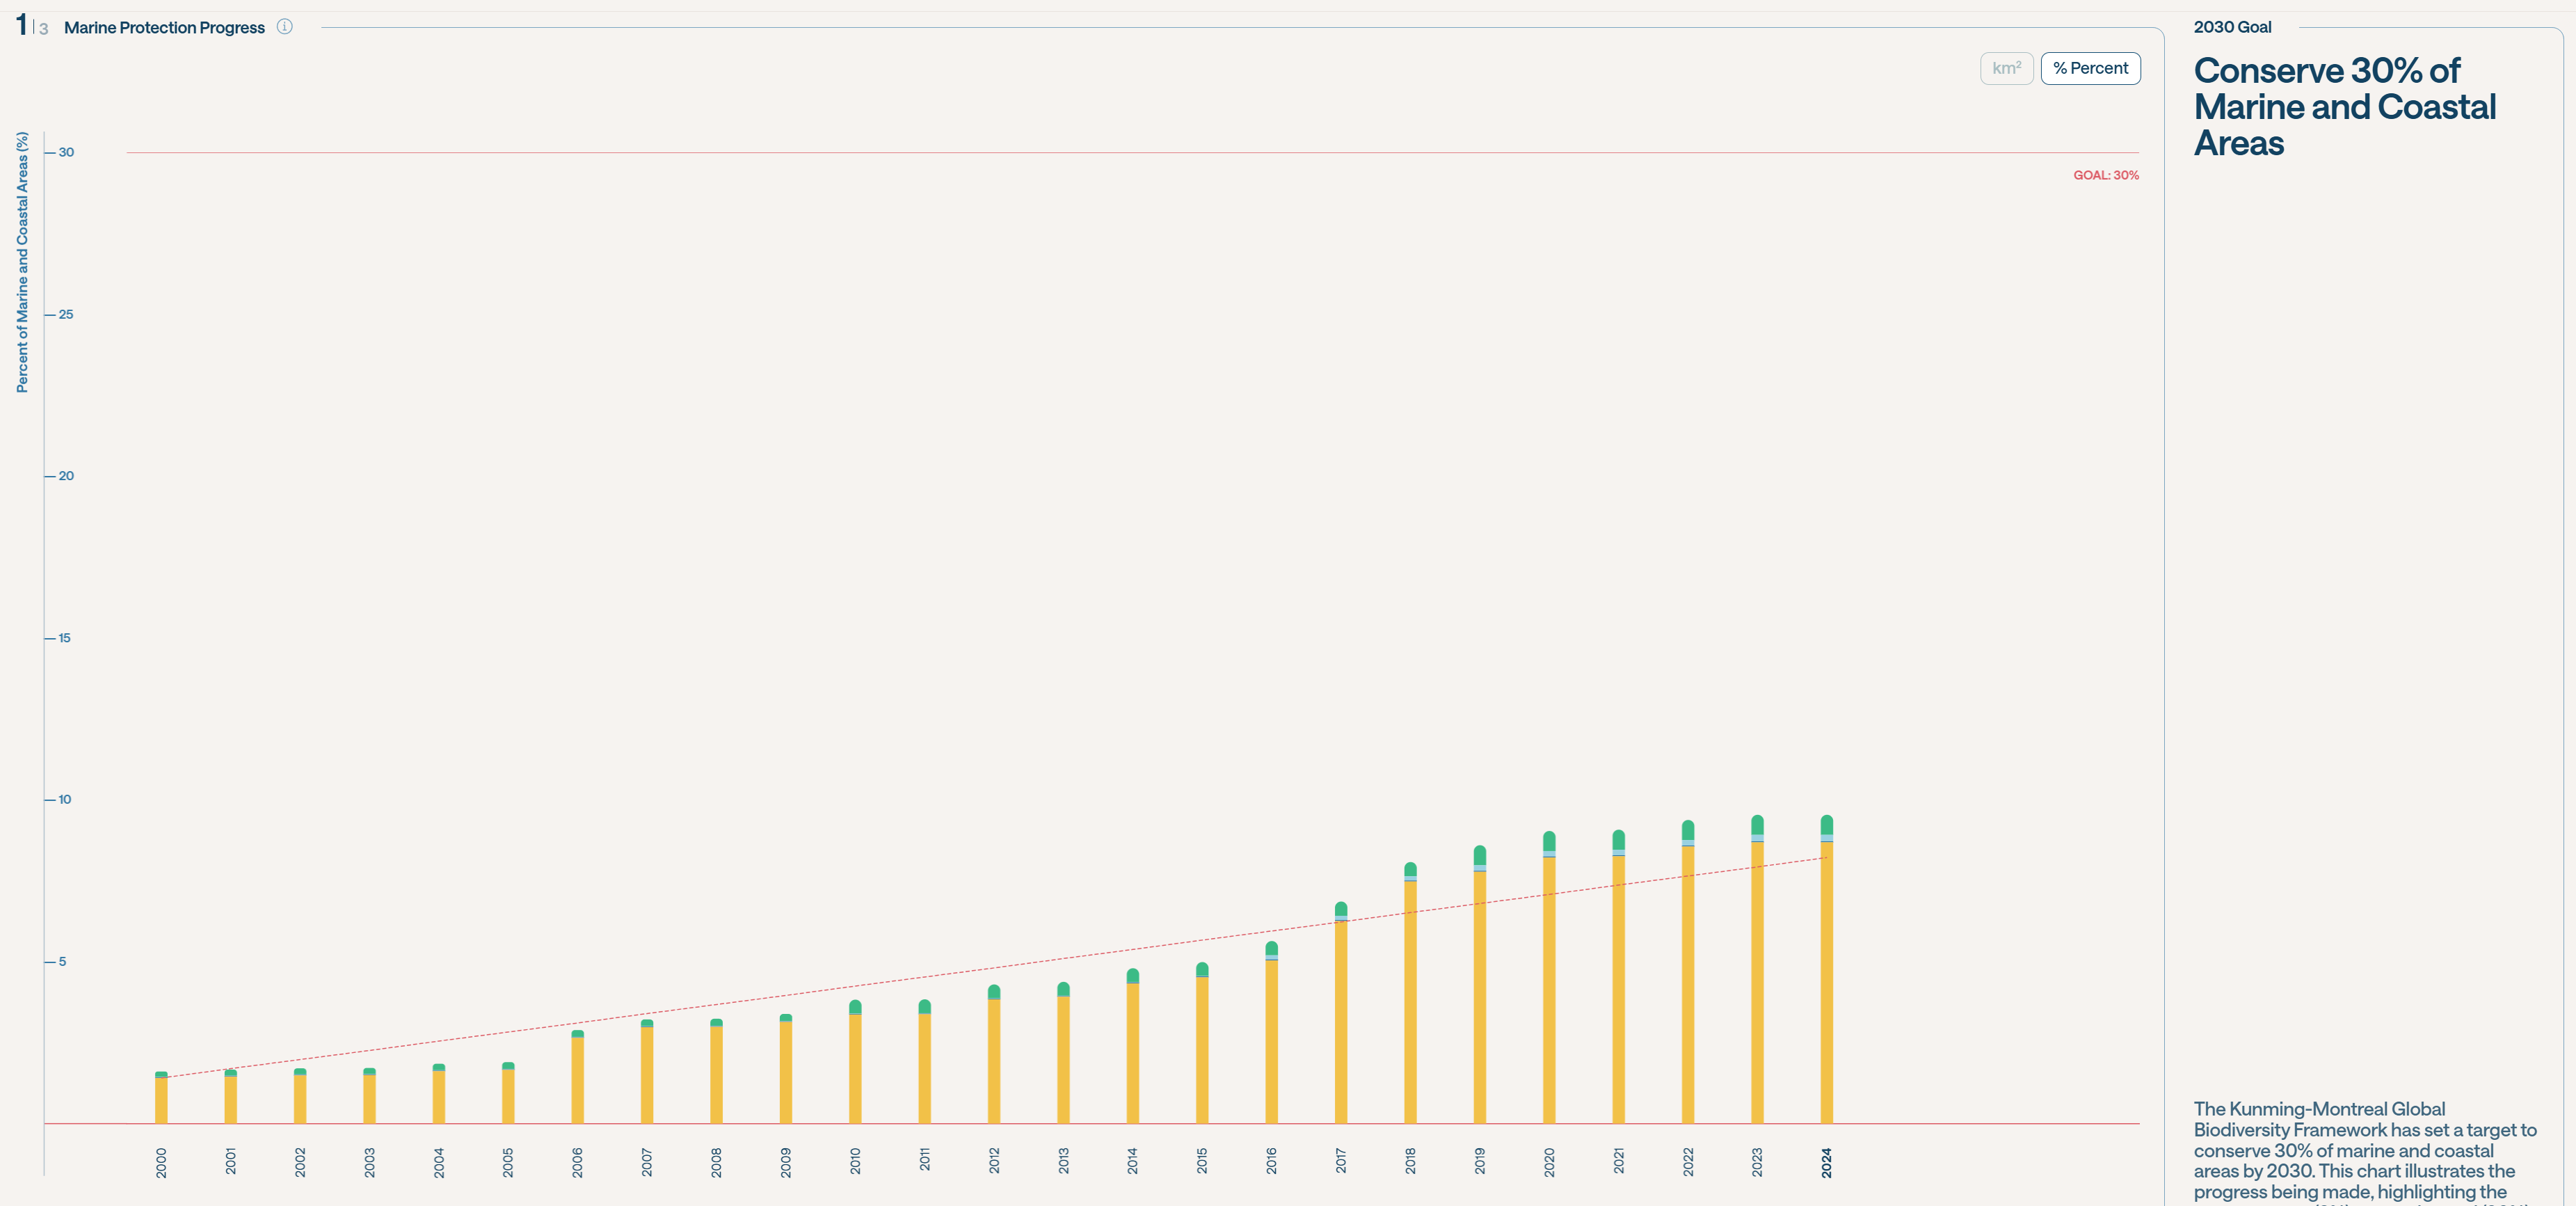

In [ ]:
# This script calculates the area of marine protected areas (MPAs) and other effective conservation measures (OECMs) by year and status.
# We make sure to dissolve polygons within each status and calculate the area of points within each status.
# This allows us to understand the amount of ocean area that is protected or conserved over time.

import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from glob import glob
import argparse

def load_data(shapetype):
    gdfs_polygons = []
    gdfs_points = []
    for filename in tqdm(glob("./data/WDPA_WDOECM_Oct2024_Public_marine_shp/*/*polygons.shp")):
        gdf = gpd.read_file(filename)
        gdfs_polygons.append(gdf)
    for filename in tqdm(glob("./data/WDPA_WDOECM_Oct2024_Public_marine_shp/*/*points.shp")):
        gdf = gpd.read_file(filename)
        gdfs_points.append(gdf)

    mpa_gdf_polygons = pd.concat(gdfs_polygons)
    mpa_gdf_points = pd.concat(gdfs_points)

    if shapetype == 'MPA':
        mpa_gdf_polygons = mpa_gdf_polygons[mpa_gdf_polygons['PA_DEF'] == '1']
        mpa_gdf_points = mpa_gdf_points[mpa_gdf_points['PA_DEF'] == '1']
    elif shapetype == 'OECM':
        mpa_gdf_polygons = mpa_gdf_polygons[mpa_gdf_polygons['PA_DEF'] == '0']
        mpa_gdf_points = mpa_gdf_points[mpa_gdf_points['PA_DEF'] == '0']

    print("Projecting data to Mollweide...")
    mpa_gdf_polygons = mpa_gdf_polygons.to_crs("ESRI:54009")  # Convert to Mollweide projection
    mpa_gdf_points = mpa_gdf_points.to_crs("ESRI:54009")  # Convert to Mollweide projection

    print("Filtering data...")
    mpa_gdf_polygons = mpa_gdf_polygons[mpa_gdf_polygons["MARINE"] != "0"]  # Only keep marine protected areas
    mpa_gdf_points = mpa_gdf_points[mpa_gdf_points["MARINE"] != "0"]  # Only keep marine protected areas

    # Buffer trick fixes invalid geometries
    mpa_gdf_polygons["geometry"] = mpa_gdf_polygons["geometry"].buffer(0)  # Fix invalid geometries
    mpa_gdf_points["geometry"] = mpa_gdf_points["geometry"].buffer(0)  # Fix invalid geometries

    return mpa_gdf_polygons, mpa_gdf_points


def calculate_areas(mpa_gdf_polygons, mpa_gdf_points, start_year, end_year, shapetype):
    results = []
    for year in tqdm(range(start_year, end_year + 1), desc="Processing years"):
        current_polygons = mpa_gdf_polygons[mpa_gdf_polygons["STATUS_YR"] <= year]
        current_points = mpa_gdf_points[mpa_gdf_points["STATUS_YR"] <= year]
        
        # Dissolve polygons within each status
        polygon_areas = current_polygons.dissolve(by='STATUS', aggfunc='sum').to_crs("ESRI:54009")
        polygon_areas['area_km2'] = polygon_areas.geometry.area / 1e6
        
        # Calculate point areas
        point_areas = current_points.groupby('STATUS')['REP_M_AREA'].sum().reset_index()
        point_areas.columns = ['STATUS', 'area_km2']
        
        # Combine polygon and point areas
        combined_areas = pd.concat([polygon_areas['area_km2'], point_areas.set_index('STATUS')['area_km2']])
        combined_areas = combined_areas.groupby('STATUS').sum().reset_index()
        
        combined_areas['year'] = year
        results.append(combined_areas)

        temp_df = pd.concat(results).fillna(0)
        temp_df = temp_df.groupby(['year', 'STATUS'])['area_km2'].sum().reset_index()
        temp_df = temp_df.pivot(index='year', columns='STATUS', values='area_km2').reset_index()
        temp_df = temp_df.fillna(0)
        temp_df = temp_df.round(2)
        temp_df.to_csv(f"mpa_time_series_{shapetype}_{start_year}_{end_year}_temp.csv", index=False)

    final_df = pd.concat(results).fillna(0)
    final_df = final_df.pivot(index='year', columns='STATUS', values='area_km2').reset_index()
    final_df = final_df.fillna(0)
    final_df = final_df.round(2)
    
    return final_df

def main():
    parser = argparse.ArgumentParser(description="Calculate MPA areas by year and status.")
    parser.add_argument('shapetype', type=str, help='All, MPA, or OECM')
    parser.add_argument("--start_year", type=int, help="Start year for calculation")
    parser.add_argument("--end_year", type=int, help="End year for calculation")
    args = parser.parse_args()

    mpa_gdf_polygons, mpa_gdf_points = load_data(args.shapetype)

    print(mpa_gdf_polygons["STATUS"].unique())

    initial_polygons = mpa_gdf_polygons[mpa_gdf_polygons["STATUS_YR"] == 0]
    initial_points = mpa_gdf_points[mpa_gdf_points["STATUS_YR"] == 0]

    initial_statuses = set(initial_polygons["STATUS"]).union(set(initial_points["STATUS"]))

    initial_areas_and_statuses = []
    for status in initial_statuses:
        area = initial_polygons[initial_polygons["STATUS"] == status].geometry.area.sum() / 1e6
        area += initial_points[initial_points["STATUS"] == status]["REP_M_AREA"].sum()
        initial_areas_and_statuses.append({"STATUS": status, "area_km2": area})

    if args.start_year is None:
        args.start_year = min(mpa_gdf_polygons["STATUS_YR"].min(), mpa_gdf_points["STATUS_YR"].min())
    if args.end_year is None:
        args.end_year = max(mpa_gdf_polygons["STATUS_YR"].max(), mpa_gdf_points["STATUS_YR"].max())

    result_df = calculate_areas(mpa_gdf_polygons, mpa_gdf_points, args.start_year, args.end_year, args.shapetype)

    for area_status in initial_areas_and_statuses:
        status = area_status["STATUS"]
        if status not in result_df.columns:
            result_df[status] = 0
        result_df[status] += area_status["area_km2"]
    
    output_file = f"mpa_time_series_{args.shapetype}_{args.start_year}_{args.end_year}.csv"
    result_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    main()

In [ ]:
# The trendline is calculated below. We're choosing to do a simple linear regression for ease of interpretation.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

cumulative_data = pd.read_csv("./mpa_time_series_MPA_final_whittled_w_established.csv")
cumulative_data.rename(columns={"year": "Year"}, inplace=True)
cumulative_data.index = cumulative_data["Year"]

trend_tag = "percent" # "km2" or "percent"

shapetype = "MPA" # "MPA" or "OECM" or "All"

# Assuming cumulative_data is already defined
x = cumulative_data.index.values.reshape(-1, 1)
y = cumulative_data[["Marine Protected Area (MPA)", "Other Effective Area-based Conservation Measure (OECM)"]].sum(axis=1).values

# Shift the x values to start from 0
x_shifted = x - x[0]

# Fit a linear regression model through the origin
model = LinearRegression(fit_intercept=False)
model.fit(x_shifted, y - y[0])

# Calculate the slope and intercept
slope = model.coef_[0]
intercept = y[0]

# Predict values
x_future = np.arange(x[0], 2031).reshape(-1, 1)
y_future = slope * (x_future - x[0]) + intercept

# Plot for local display if needed
# plt.figure(figsize=(12, 6))
# plt.scatter(x, y, label="Real Data", color='blue')
# plt.plot(x_future, y_future, label="Linear Trend", color='red', linestyle='--')
# plt.xlabel("Year")
# plt.ylabel("Area (km²)")
# plt.title("Anchored Linear Trend of Cumulative Area of Marine Protected Areas by 2030")
# plt.legend()
# plt.grid(True)

# Add the equation to the plot
equation = f"y = {slope:.2f}(x - {x[0][0]}) + {intercept:.2f}"
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# Print the equation of the line
print(f"Equation of the line: {equation}")

# Calculate R-squared
y_pred = slope * x_shifted + intercept
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.4f}")

y_future = [y[0] for y in y_future]

# Output trend data
trend_data = pd.DataFrame({
    "Year": x_future.flatten(),
    "Linear Trend": y_future
})
# Merge predictions with real data
data = pd.merge(cumulative_data, trend_data, left_index=True, right_on="Year", how="outer")
data.drop(columns=["Year_x", "Year_y"], inplace=True)
data.to_csv(f"./data_for_export/protected_spaces_1_{shapetype}_{trend_tag}.csv", index=False)

## Global Ecosystem Protection (2)

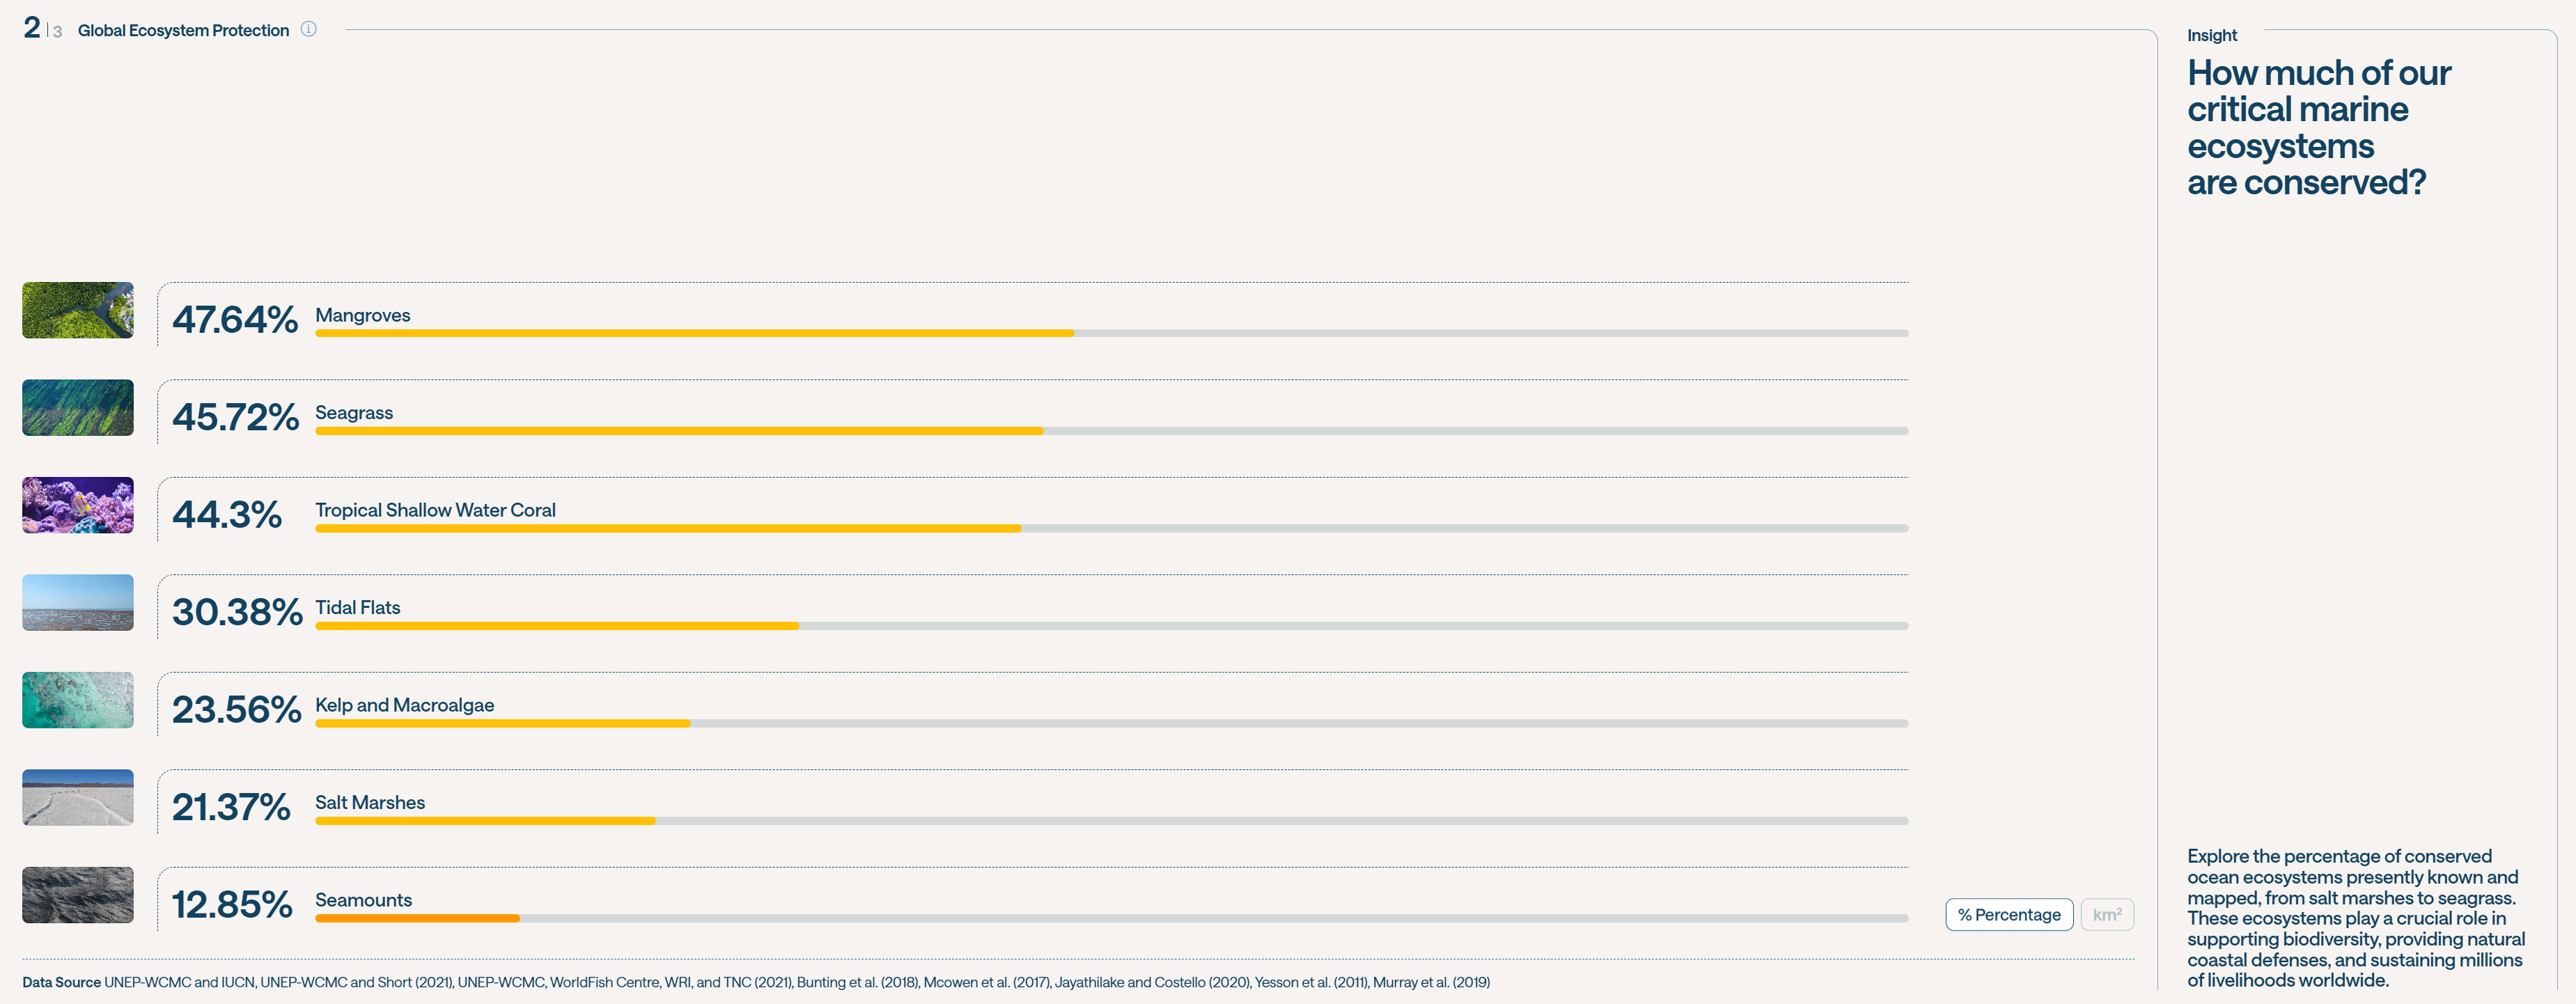

Data processing for this figure was done in QGIS. The following are relevant notes to the process.

1. For those polygons with incorrect geometries, the geometries were corrected with the `Fix Geometries` method.
2. Marine Protected Areas (MPAs) were `dissolved` into a single shape to remove double counting due to overlaps.
3. The ecosystems were also `dissolved` into single shapes for double counting purposes.
4. The `intersection` was taken between the dissolved MPA shape and each of the dissolved ecosystems.
5. The area of the intersection was then divided by the total area of the ecosystem to get the % protected.

## Protection by Country (3)

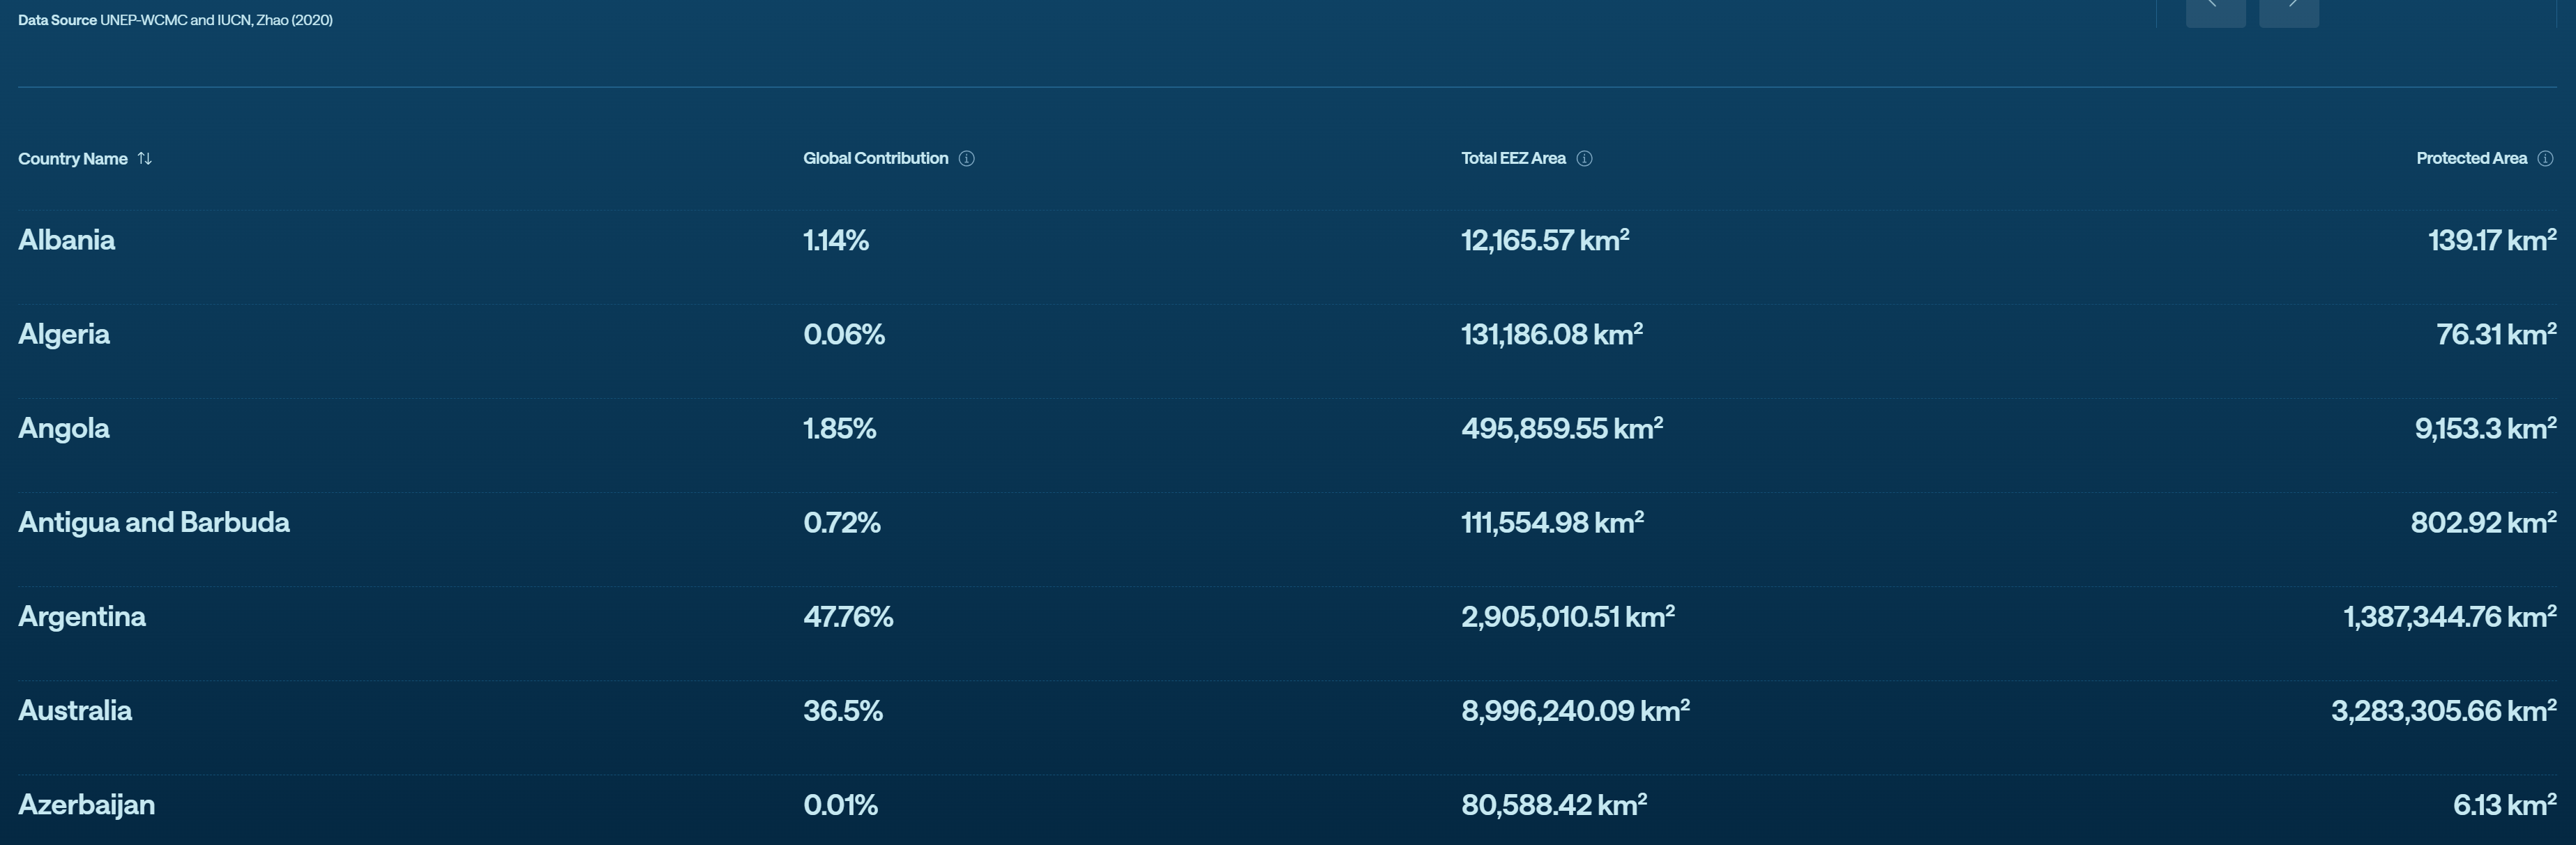

In [ ]:
# We're borrowing the highly performant code from Restore Ecosystems to calculate this overlap.

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
import numpy as np

# For Mangroves: Flanders Marine Institute (2024). Union of the ESRI Country shapefile and the Exclusive Economic Zones (version 4).

def main():
    # Parse CLI arguments
    parser = argparse.ArgumentParser(description='Process EEZs based on start and end percentages.')
    parser.add_argument('start_percentage', type=float, help='Start percentage (between 0 and 100)')
    parser.add_argument('end_percentage', type=float, help='End percentage (between 0 and 100)')
    parser.add_argument('protection_type', type=str, help='Protection type (Total, MPA or OECM)')
    args = parser.parse_args()
    
    start_percentage = args.start_percentage
    end_percentage = args.end_percentage
    protection_type = args.protection_type

    print("Loading data...")
    # These parquet files were pre-processed by:
    # 1. Fixing invalid geometries
    # 2. Dissolving overlapping geometries
    # 3. Keeping protected areas with marine components only

    if protection_type == "total":
        mpa_gdf = gpd.read_parquet(f"./data/{protection_type}_dissolved_disjoint_fixed.parquet")
    else:
        mpa_gdf = gpd.read_parquet(f"./data/{protection_type}_dissolved_disjoint.parquet")
    
    eez_gdf = gpd.read_file('data/World_EEZ_v12_20231025_gpkg/eez_v12.gpkg')

    if not (0 <= start_percentage <= 100) or not (0 <= end_percentage <= 100):
        raise ValueError("Start and end percentages must be between 0 and 100.")
    if start_percentage >= end_percentage:
        raise ValueError("Start percentage must be less than end percentage.")

    total_eezs = len(eez_gdf)
    start_index = int(start_percentage / 100 * total_eezs)
    end_index = int(end_percentage / 100 * total_eezs)
    eez_gdf = eez_gdf.iloc[start_index:end_index]

    ecosystem_dict = {"eezs": eez_gdf}  # This is a little trick to reuse the performance ecosystems code

    INITIAL_CRS = 'ESRI:54009'

    print("Converting data to uniform CRS...")
    print("Before CRS conversion:")
    print("EEZ CRS:", eez_gdf.crs)
    print("MPA CRS:", mpa_gdf.crs)
    for name, gdf in ecosystem_dict.items():
        print(f"{name} CRS:", gdf.crs)

    eez_gdf = eez_gdf.to_crs(INITIAL_CRS)
    mpa_gdf = mpa_gdf.to_crs(INITIAL_CRS)
    ecosystem_dict = {name: gdf.to_crs(INITIAL_CRS) for name, gdf in ecosystem_dict.items()}

    print("\nAfter CRS conversion:")
    print("EEZ CRS:", eez_gdf.crs)
    print("MPA CRS:", mpa_gdf.crs)
    for name, gdf in ecosystem_dict.items():
        print(f"{name} CRS:", gdf.crs)

    # Create spatial indices
    print("Creating spatial indices...")
    mpa_sindex = mpa_gdf.sindex
    ecosystem_sindices = {name: gdf.sindex for name, gdf in ecosystem_dict.items()}

    # Debug: Print bounds
    print("\nBounding boxes:")
    print("EEZ bounds:", eez_gdf.total_bounds)
    print("MPA bounds:", mpa_gdf.total_bounds)

    DEBUG = False
    print("Starting data preprocessing...")

    output_dict = {"MRGID": []}
    for ecosystem_name in ecosystem_dict.keys():
        output_dict[f"{ecosystem_name}_area"] = []
        output_dict[f"{ecosystem_name}_protected_area"] = []

    print(f"Processing {len(eez_gdf)} EEZs...")

    for eez_row_index in tqdm(range(len(eez_gdf)), desc="Processing EEZs"):
        eez_row = eez_gdf.iloc[[eez_row_index]]
        mrgid = eez_row.MRGID.values[0]
        output_dict["MRGID"].append(mrgid)
        print(f"\nProcessing EEZ with MRGID: {mrgid}")

        # Get the bounds of the current EEZ
        eez_bounds = eez_row.total_bounds
        print(f"EEZ bounds: {eez_bounds}")

        possible_mpa_matches_idx = list(mpa_sindex.intersection(eez_bounds))
        if possible_mpa_matches_idx:
            possible_mpa_matches = mpa_gdf.iloc[possible_mpa_matches_idx]
        else:
            print("No potential MPA matches found for this EEZ!")

        for ecosystem_name, ecosystem_gdf in ecosystem_dict.items():
            print(f"  Analyzing {ecosystem_name}...")
            
            # Use spatial index to find potential intersections

            possible_matches_idx = list(ecosystem_sindices[ecosystem_name].intersection(eez_bounds))
            if possible_matches_idx:
                possible_matches = ecosystem_gdf.iloc[possible_matches_idx]

                # Because we're using the protected area as the 'ecosystem', this will return the same area of the EEZ that's protected
                ecosystem_intersection = gpd.overlay(eez_row, possible_matches, how="intersection", keep_geom_type=False)
                
                if not ecosystem_intersection.empty:
                    print(f"    Intersection found for {ecosystem_name}")
                    ecosystem_intersection.geometry = ecosystem_intersection.buffer(0)
                    ecosystem_area = ecosystem_intersection.dissolve().area.sum()
                    output_dict[f"{ecosystem_name}_area"].append(ecosystem_area)
                    print(f"    Ecosystem area: {ecosystem_area:.2f} square meters")
                    
                    try:
                        # Use spatial index for MPA intersection
                        possible_mpa_idx = list(mpa_sindex.intersection(ecosystem_intersection.total_bounds))
                        if possible_mpa_idx:
                            possible_mpa_matches = mpa_gdf.iloc[possible_mpa_idx]
                            
                            mpa_intersection = gpd.overlay(
                                possible_mpa_matches, ecosystem_intersection, 
                                how="intersection", keep_geom_type=False
                            )
                            
                            if not mpa_intersection.empty:
                                mpa_intersection.geometry = mpa_intersection.buffer(0)
                                protected_area = mpa_intersection.dissolve().area.sum()
                                print(f"    Protected area: {protected_area:.2f} square meters")

                            else:
                                protected_area = 0
                                print("    No protected area found after overlay")
                            
                            output_dict[f"{ecosystem_name}_protected_area"].append(protected_area)
                        else:
                            output_dict[f"{ecosystem_name}_protected_area"].append(0)
                            print("    No potential MPA intersections found")
                            
                    except NotImplementedError as e:
                        print(f"    Error encountered: {e}")
                        print(f"    Skipping protected area calculation for {ecosystem_name} in EEZ {mrgid}")
                        output_dict[f"{ecosystem_name}_protected_area"].append(np.nan)
                    except Exception as e:
                        print(f"    Unexpected error: {e}")
                        print(f"    Skipping protected area calculation for {ecosystem_name} in EEZ {mrgid}")
                        output_dict[f"{ecosystem_name}_protected_area"].append(np.nan)
                else:
                    print(f"    No actual intersection found for {ecosystem_name}")
                    output_dict[f"{ecosystem_name}_area"].append(0)
                    output_dict[f"{ecosystem_name}_protected_area"].append(0)
            else:
                print(f"    No potential intersections found for {ecosystem_name}")
                output_dict[f"{ecosystem_name}_area"].append(0)
                output_dict[f"{ecosystem_name}_protected_area"].append(0)

        # Save temporary results
        max_length = max(len(output_dict[col]) for col in output_dict)
        for col in output_dict:
            if len(output_dict[col]) < max_length:
                output_dict[col].append(0)
        output_df = pd.DataFrame(output_dict)
        # output_df.to_csv(f"restore_ecosystems_{start_percentage}_{end_percentage}_{protection_type}_temp_no_utm.csv", index=False)
        output_df.to_csv(f"protect_spaces_eezs_{start_percentage}_{end_percentage}_{protection_type}_temp_no_utm.csv", index=False)

    print("\nProcessing complete. Creating output DataFrame...")
    output_df = pd.DataFrame(output_dict)
    output_df.to_csv(f"protect_spaces_eezs_{start_percentage}_{end_percentage}_{protection_type}_no_utm.csv", index=False)
    print("Output DataFrame created.")
    print(f"Total rows in output: {len(output_df)}")
    print("Script execution complete.")

if __name__ == "__main__":
    main()

## Critical Area Protection by Country (4)